In [1]:
import numpy as np

import pandas as pd  # version 1.0.3

from xgboost import XGBClassifier, plot_importance  # version 1.0.2

import shap  # version 0.35.0

from ipywidgets import interact_manual, fixed, widgets  # version 7.5.1

from socceraction.vaep.formula import value # version 0.2.0

import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

# Load dataset

## Load games

Use the trained models to rate actions for all actions from the 2017/2018 English Premier League (competition_id = 364). Therefore, we make sure that we don't use this data when training and tuning the model.

In [3]:
df_games = pd.read_hdf('spadl.h5', key='games')

# Split Games into Training and test sets

We take 60% of the data for training and 40% for test.

In [4]:
df_games_train = df_games[
    df_games['competition_id'] == 364
][:int(len(df_games)*0.6)]

In [5]:
df_games_train.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
218,2499883,364,181150,2017-12-12 20:00:00,1628,1644
219,2499879,364,181150,2017-12-12 19:45:00,1646,1639
220,2499873,364,181150,2017-12-10 16:30:00,1611,1625
221,2499872,364,181150,2017-12-10 14:15:00,1612,1623
222,2499875,364,181150,2017-12-10 12:00:00,1619,1609
223,2499874,364,181150,2017-12-09 17:30:00,1613,1631
224,2499869,364,181150,2017-12-09 15:00:00,1646,1644
225,2499870,364,181150,2017-12-09 15:00:00,1628,1659
226,2499871,364,181150,2017-12-09 15:00:00,1673,1651
227,2499876,364,181150,2017-12-09 15:00:00,10531,1627


In [6]:
df_games_test = df_games[
    df_games['competition_id'] == 364
][int(len(df_games)*0.6):]

In [7]:
df_games_test.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
370,2499724,364,181150,2017-08-13 15:00:00,1611,1633
371,2499725,364,181150,2017-08-13 12:30:00,1613,1624
372,2499720,364,181150,2017-08-12 16:30:00,1651,1625
373,2499721,364,181150,2017-08-12 14:00:00,1610,1646
374,2499722,364,181150,2017-08-12 14:00:00,1628,1673
375,2499723,364,181150,2017-08-12 14:00:00,1623,1639
376,2499726,364,181150,2017-08-12 14:00:00,1619,10531
377,2499728,364,181150,2017-08-12 14:00:00,1627,1659
378,2499727,364,181150,2017-08-12 11:30:00,1644,1612
379,2499719,364,181150,2017-08-11 18:45:00,1609,1631


## Load Features

Load the features for the selected games and combine them into the df_features DataFrame object.

In [8]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
df_features = pd.concat(dfs_features).reset_index(drop=True)

100%|██████████| 380/380 [00:09<00:00, 38.16it/s]


In [9]:
df_features.tail(10)

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post,game_id
483655,2499719.0,2.0,2983.268603,1609.0,14869.0,60.90,57.12,84.00,52.36,0,...,0.62,0.70,42.154122,2.933824,37.80,-10.88,58.296128,60.90,-15.64,2499719
483656,2499719.0,2.0,2985.152095,1631.0,8488.0,84.00,52.36,84.00,52.36,0,...,0.54,0.87,54.460220,1.919714,27.30,-6.80,55.358314,27.30,-6.80,2499719
483657,2499719.0,2.0,2985.152095,1631.0,8488.0,84.00,52.36,78.75,48.96,1,...,0.20,0.23,85.983077,4.575163,39.90,41.48,1.883492,34.65,38.08,2499719
483658,2499719.0,2.0,2986.855919,1631.0,265366.0,78.75,48.96,73.50,46.24,0,...,0.80,0.77,27.894257,1.143791,-5.25,-3.40,1.703824,-10.50,-6.12,2499719
483659,2499719.0,2.0,2988.398325,1609.0,7870.0,73.50,46.24,93.45,46.24,0,...,0.25,0.28,80.158369,5.264037,52.50,30.60,3.246230,72.45,30.60,2499719
483660,2499719.0,2.0,2990.768201,1631.0,8653.0,93.45,46.24,97.65,36.04,0,...,0.70,0.68,33.794491,2.573529,14.70,-2.72,3.912282,18.90,-12.92,2499719
483661,2499719.0,2.0,2992.491575,1631.0,8480.0,97.65,36.04,56.70,33.32,0,...,0.11,0.32,94.248184,7.634804,66.15,14.28,4.093250,25.20,11.56,2499719
483662,2499719.0,2.0,2994.900590,1609.0,49876.0,56.70,33.32,76.65,28.56,1,...,0.07,0.47,97.671306,47.867647,45.15,11.56,4.132389,65.10,6.80,2499719
483663,2499719.0,2.0,2997.086392,1609.0,7870.0,76.65,28.56,105.00,27.20,0,...,0.46,0.51,56.704077,83.382353,69.30,-3.40,4.594817,97.65,-4.76,2499719
483664,2499719.0,2.0,3006.647279,1631.0,8480.0,100.00,34.00,0.00,68.00,0,...,0.27,0.58,76.842801,14.090074,51.70,-0.68,11.746689,-48.30,33.32,2499719


## Load labels

Load the labels for the selected games and combine them into the df_labels DataFrame object.

In [10]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']  
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

100%|██████████| 380/380 [00:03<00:00, 103.37it/s]


In [11]:
df_labels.tail(10)

,scores,concedes,game_id
483655,False,False,2499719
483656,False,False,2499719
483657,False,False,2499719
483658,False,False,2499719
483659,False,False,2499719
483660,False,False,2499719
483661,False,False,2499719
483662,False,False,2499719
483663,False,False,2499719
483664,False,False,2499719


## Final Splitting the data into X_train,X_test,Y_Train,Y_test

In [12]:
df_X_train = df_features[df_features['game_id'].isin(df_games_train['game_id'].unique())]
df_X_test = df_features[df_features['game_id'].isin(df_games_test['game_id'].unique())]
df_y_train = df_labels[df_labels['game_id'].isin(df_games_train['game_id'].unique())]
df_y_test = df_labels[df_labels['game_id'].isin(df_games_test['game_id'].unique())]

In [13]:
df_X_train.columns

Index(['game_id-0', 'period_id-0', 'time_seconds-0', 'team_id-0',
       'player_id-0', 'start_x-0', 'start_y-0', 'end_x-0', 'end_y-0',
       'bodypart_id-0', 'type_id-0', 'result_id-0', 'type_name-0',
       'result_name-0', 'bodypart_name-0', 'time_played-0', 'game_id-1',
       'period_id-1', 'time_seconds-1', 'team_id-1', 'player_id-1',
       'start_x-1', 'start_y-1', 'end_x-1', 'end_y-1', 'bodypart_id-1',
       'type_id-1', 'result_id-1', 'type_name-1', 'result_name-1',
       'bodypart_name-1', 'time_played-1', 'game_id-2', 'period_id-2',
       'time_seconds-2', 'team_id-2', 'player_id-2', 'start_x-2', 'start_y-2',
       'end_x-2', 'end_y-2', 'bodypart_id-2', 'type_id-2', 'result_id-2',
       'type_name-2', 'result_name-2', 'bodypart_name-2', 'time_played-2',
       'team-1', 'team-2', 'start_x_norm-0', 'start_y_norm-0',
       'start_distance_to_goal-0', 'start_angle_to_goal-0', 'diff_x-0',
       'diff_y-0', 'distance_covered-0', 'end_x_norm-0', 'end_y_norm-0',
       'en

The following cell provides a list of features that the machine learning algorithm will consider to train the model. The selected features exist in the features.h5 file that was created using [Value 2](https://github.com/utkarshshri1016/Soccer-and-Stats/blob/master/Value%202.ipynb).

In [14]:
features = [
    'start_distance_to_goal-0',
    'end_distance_to_goal-0',
    'start_distance_to_goal-1',
    'end_distance_to_goal-1',
    'start_distance_to_goal-2',
    'end_distance_to_goal-2',
    'start_angle_to_goal-0',
    'end_angle_to_goal-0',
    'start_angle_to_goal-1',
    'end_angle_to_goal-1',
    'start_angle_to_goal-2',
    'end_angle_to_goal-2',
    'team-1',
    'team-2',
    'result_id-0',
    'result_id-1',
    'result_id-2'
]

In [15]:
labels = [
    'scores',
    'concedes'
]

# Train classifiers

The following cell trains an XGBoost classifier for each label using conservative hyperparamters for the learning algorithm, which will serve as baseline models.

In [16]:
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        n_estimators=100,
        max_depth=3
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model

100%|██████████| 2/2 [00:15<00:00,  7.97s/it]


# Investigate feature importances

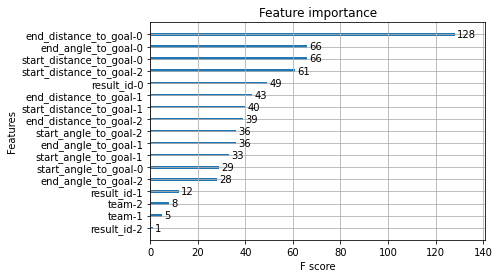

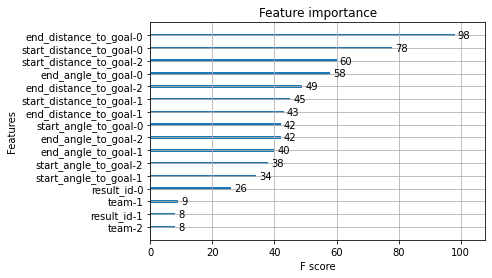

In [17]:
for label in labels:
    plot_importance(models[label])

# Investigate SHAP values

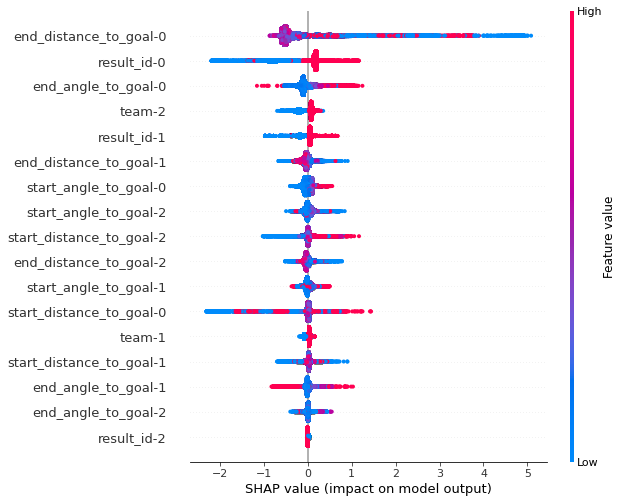

In [18]:
label='scores'
#label='concedes'

explainer = shap.TreeExplainer(models[label])

shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

# Estimate probabilities

The following cell estimates the probabilities for the game states in the test set for each label using the trained models.

In [19]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1).reset_index(drop=True)

100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


In [20]:
df_predictions.tail(10)

,scores,concedes
193166,0.007425,0.005290
193167,0.010342,0.007351
193168,0.010072,0.006609
193169,0.003733,0.005212
193170,0.022580,0.004618
193171,0.052056,0.019514
193172,0.002212,0.008836
193173,0.012253,0.001301
193174,0.010334,0.004499
193175,0.010207,0.010280


# Load actions, players and teams and value actions

In [21]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [22]:
dfs_actions = []
for _, game in tqdm(df_games_test.iterrows(), total=len(df_games_test)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .merge(spadlstore['players'], how='left')
            .merge(spadlstore['teams'], how='left')
            .reset_index()
            .rename(columns={'index': 'action_id'})
        )
    
    dfs_actions.append(df_actions)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

100%|██████████| 152/152 [00:21<00:00,  7.17it/s]


In [23]:
df_actions_predictions = pd.concat([df_actions, df_predictions], axis=1)

In [24]:
dfs_values = []
for game_id, game_predictions in df_actions_predictions.groupby('game_id'):
    df_values = value(game_predictions, game_predictions['scores'], game_predictions['concedes'])
    
    df_all = pd.concat([game_predictions, df_values], axis=1)
    dfs_values.append(df_all)

In [25]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [26]:
df_values.tail(10)

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,first_name,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
193166,1164,2500036.0,2.0,2726.411784,1619.0,8144.0,69.30,25.16,53.55,30.60,...,James,Ward-Prowse,1994-11-01,Southampton,Southampton FC,0.015848,0.000932,0.000805,0.000580,0.001385
193167,1165,2500036.0,2.0,2729.374371,1619.0,8136.0,53.55,30.60,67.20,55.76,...,Jack,Stephens,1994-01-27,Southampton,Southampton FC,0.012889,0.001095,-0.002959,-0.000163,-0.003122
193168,1166,2500036.0,2.0,2732.487619,1619.0,7885.0,67.20,55.76,73.50,22.44,...,Ryan,Bertrand,1989-08-05,Southampton,Southampton FC,0.026000,0.001408,0.013111,-0.000314,0.012797
193169,1167,2500036.0,2.0,2737.344209,1619.0,8144.0,73.50,22.44,95.55,42.16,...,James,Ward-Prowse,1994-11-01,Southampton,Southampton FC,0.056922,0.002420,0.030922,-0.001012,0.029911
193170,1168,2500036.0,2.0,2741.953737,1633.0,8313.0,95.55,42.84,95.55,42.84,...,Pablo Javier,Zabaleta Girod,1985-01-16,West Ham United,West Ham United FC,0.024306,0.046637,0.021886,0.010285,0.032171
193171,1169,2500036.0,2.0,2840.764678,1619.0,8953.0,94.50,35.36,105.00,34.00,...,Charlie,Austin,1989-07-05,Southampton,Southampton FC,0.947150,0.007448,0.154697,-0.007448,0.147249
193172,1170,2500036.0,2.0,2914.422707,1633.0,8561.0,36.75,51.68,58.80,29.24,...,Mark,Noble,1987-05-08,West Ham United,West Ham United FC,0.009457,0.002149,0.009457,-0.002149,0.007308
193173,1171,2500036.0,2.0,2917.129803,1633.0,8561.0,58.80,29.24,46.20,7.48,...,Mark,Noble,1987-05-08,West Ham United,West Ham United FC,0.014308,0.001188,0.004851,0.000961,0.005812
193174,1172,2500036.0,2.0,2919.288906,1633.0,8582.0,46.20,7.48,0.00,23.12,...,Aaron,Cresswell,1989-12-15,West Ham United,West Ham United FC,0.006966,0.003002,-0.007342,-0.001814,-0.009155
193175,1173,2500036.0,2.0,2953.790162,1619.0,61941.0,5.00,34.00,0.00,68.00,...,Fraser,Forster,1988-03-17,Southampton,Southampton FC,0.004560,0.030157,0.004560,-0.030157,-0.025597


# Rate players

Investigate the ratings per player and look at the quantity-quality trade-off, risk-reward trade-off and the rating per player per action type (e.g. shot, pass, tackle, etc.)

In [27]:
df_ranking = (df_values[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), 
         vaep_mean=('vaep_value', 'mean'),
         vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [28]:
df_ranking.head(10)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum
0,8717.0,Tottenham Hotspur FC,H. Kane,523,0.018675,9.766866
1,120353.0,Liverpool FC,Mohamed Salah,640,0.015252,9.761583
2,3324.0,Chelsea FC,Álvaro Morata,518,0.015688,8.126154
3,28292.0,Watford FC,A. Doucouré,1216,0.006458,7.852877
4,340386.0,Manchester City FC,Gabriel Jesus,425,0.015621,6.638811
5,7944.0,Everton FC,W. Rooney,667,0.009804,6.539283
6,38021.0,Manchester City FC,K. De Bruyne,1505,0.004331,6.518732
7,11066.0,Manchester City FC,R. Sterling,617,0.009974,6.153672
8,25413.0,Arsenal FC,A. Lacazette,448,0.013656,6.118053
9,8317.0,Manchester City FC,David Silva,1462,0.004179,6.109884


In [29]:
df_player_games = pd.read_hdf('spadl.h5', 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [30]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [31]:
df_minutes_played.head()

,player_id,minutes_played
0,36,1238.400194
1,38,382.741398
2,48,3344.850202
3,54,3350.424005
4,56,267.266792


In [32]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['vaep_count'] * 90 / df_ranking_p90['minutes_played']

In [33]:
MIN_THRESHOLD = 450

In [34]:
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played']>MIN_THRESHOLD]

In [35]:
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)
df_ranking_p90.head(10)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum,minutes_played,vaep_rating,actions_p90
4,340386.0,Manchester City FC,Gabriel Jesus,425,0.015621,6.638811,1728.921870,0.345587,22.123614
2,3324.0,Chelsea FC,Álvaro Morata,518,0.015688,8.126154,2143.442302,0.341205,21.750061
35,3802.0,Liverpool FC,Philippe Coutinho,637,0.006194,3.945560,1134.538547,0.312991,50.531558
1,120353.0,Liverpool FC,Mohamed Salah,640,0.015252,9.761583,2996.529579,0.293187,19.222236
137,8249.0,Manchester United FC,M. Fellaini,282,0.007654,2.158523,693.521021,0.280117,36.595863
17,134513.0,Manchester United FC,A. Martial,382,0.013389,5.114513,1650.191521,0.278941,20.833945
0,8717.0,Tottenham Hotspur FC,H. Kane,523,0.018675,9.766866,3203.994283,0.274351,14.691037
11,8325.0,Manchester City FC,S. Agüero,388,0.015150,5.878371,2038.785220,0.259494,17.127846
181,3326.0,Stoke City FC,Jesé Rodríguez,196,0.009078,1.779219,618.089176,0.259072,28.539571
5,7944.0,Everton FC,W. Rooney,667,0.009804,6.539283,2329.451894,0.252650,25.770011


# Quantity - quality trade-off

Create a figure to analyze the quantity-quality trade-off. The VAEP rating per player per 90 minutes depends on the average rating per action and the number of actions per 90 minutes. Some players have high ratings because they execute a lot of actions per 90 minutes, while others have very high average ratings

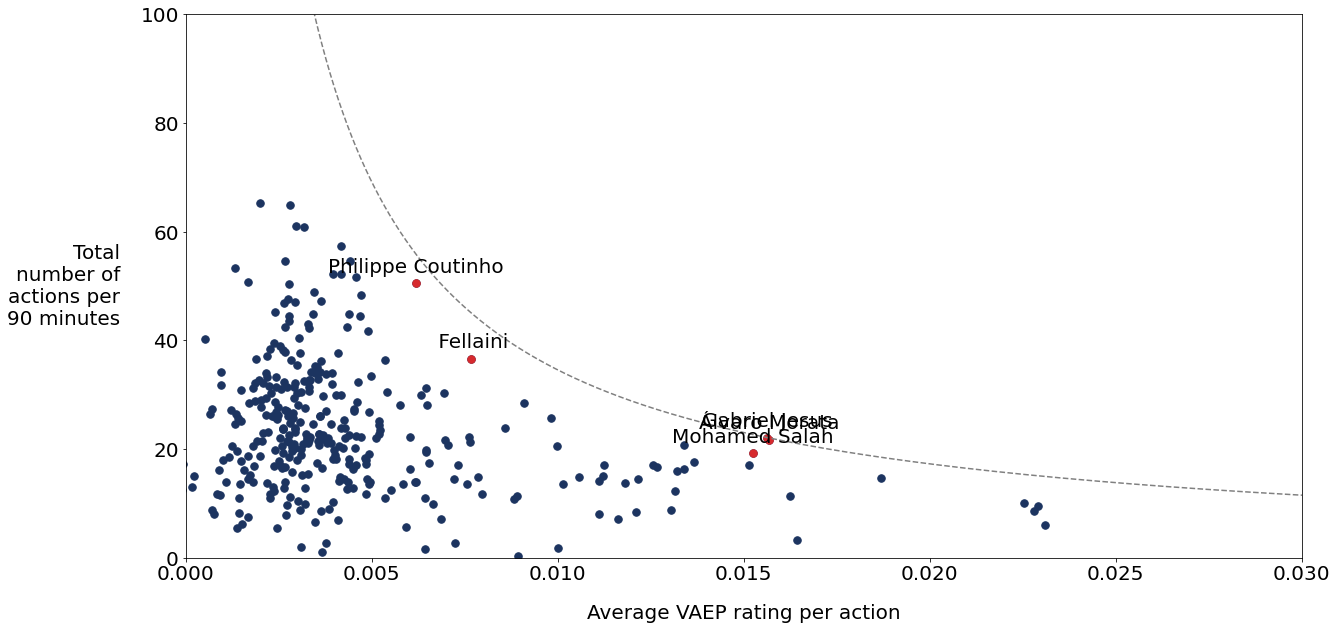

In [36]:
plt.figure(figsize=(20, 10))
x = list(df_ranking_p90['vaep_mean'])
y = list(df_ranking_p90['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_ranking_p90['vaep_mean'][0:5])
y_best = list(df_ranking_p90['actions_p90'][0:5])
names = list(df_ranking_p90['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=20, horizontalalignment='center')

best_player = x[0] * y[0]
yi = np.arange(0.1, 100, 0.1)
xi = [best_player / i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 0.03)
plt.ylim(0, 100)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total\nnumber of\nactions per\n90 minutes', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)

plt.show()

# Risk - reward trade-off

Look at the ratings for a player's successful actions and for the player's unsuccessful actions. In this way we can identify players that take more risk, and players that play less risky.

In [37]:
df_risk = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
df_risk = df_risk.reset_index()
df_risk = df_risk[0:-1]
df_risk = pd.merge(df_risk, df_minutes_played, on=['player_id'])
for result in ['success', 'fail']:
    df_risk[result] = df_risk[result] / df_risk['minutes_played'] * 90

In [38]:
df_risk = df_risk[df_risk['minutes_played']>MIN_THRESHOLD]
df_risk['vaep_rating'] = df_risk['success'] + df_risk['fail']
df_risk.sort_values('fail')

,player_id,short_name,team_name,success,fail,minutes_played,vaep_rating
207,9532.0,S. Berahino,Stoke City FC,0.024114,-0.161203,539.702359,-0.137089
209,9623.0,R. Brady,Burnley FC,0.298685,-0.152704,1331.817292,0.145981
44,3802.0,Philippe Coutinho,Liverpool FC,0.433513,-0.115879,1134.538547,0.317634
68,7907.0,D. Sturridge,Liverpool FC,0.326315,-0.113522,578.150179,0.212792
398,286831.0,D. Solanke,Liverpool FC,0.041590,-0.112394,648.265528,-0.070804
...,...,...,...,...,...,...,...
260,21164.0,F. Fernández,Swansea City AFC,0.055111,0.005842,2794.621286,0.060953
239,15215.0,C. Schindler,Huddersfield Town FC,0.080771,0.006065,3443.318209,0.086836
157,8561.0,M. Noble,West Ham United FC,0.079638,0.008038,2506.286841,0.087676
257,21095.0,M. Darmian,Manchester United FC,0.046987,0.011950,467.587408,0.058937


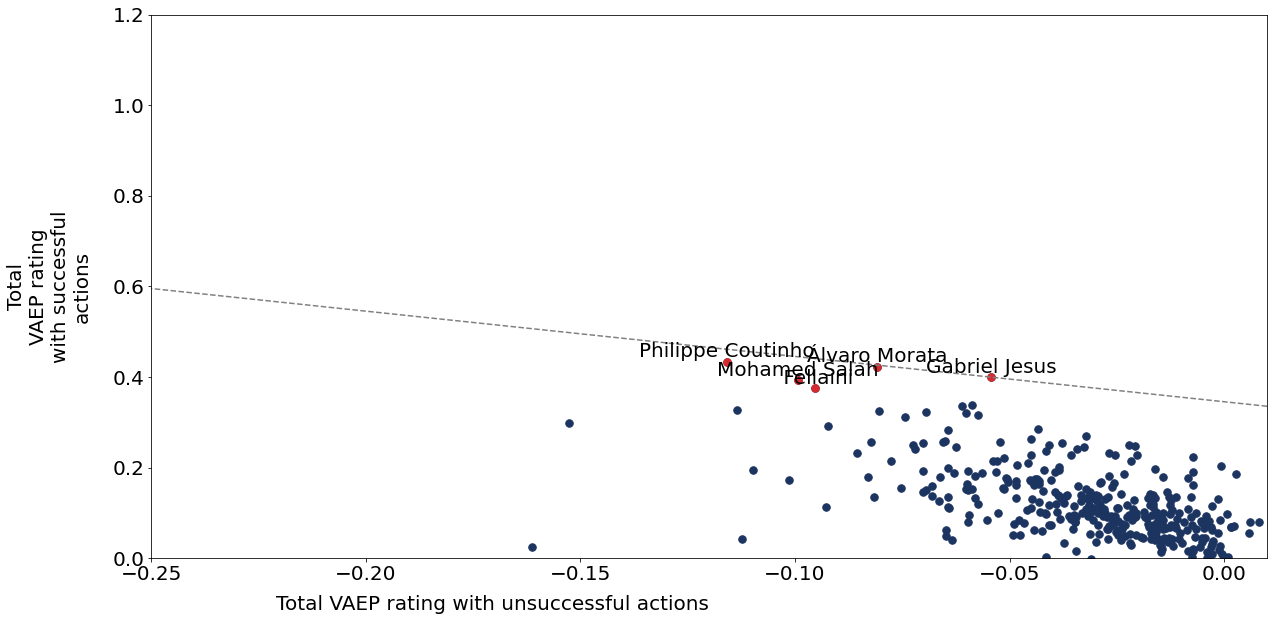

In [39]:
df_risk = df_risk.sort_values('vaep_rating', ascending=False)

plt.figure(figsize=(20, 10))
x = list(df_risk['fail'])
y = list(df_risk['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_risk['fail'][0:5])
y_best = list(df_risk['success'][0:5])
names = list(df_risk['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 0.01), fontsize=20, horizontalalignment='center')

best_player = x[0] + y[0]
yi = np.arange(0.1, 2, 0.1)
xi = [best_player - i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.25, 0.01)
plt.ylim(0, 1.2)
plt.xlabel('Total VAEP rating with unsuccessful actions', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)
plt.ylabel('Total\nVAEP rating\nwith successful\nactions', labelpad=20, fontsize=20)

plt.show()

# Rating per action type

analyze the rating per player per action type.

In [40]:
df_rating_action = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['type_name'], aggfunc=np.sum,
                                              fill_value=0, margins=True, margins_name='total')
df_rating_action = df_rating_action.reset_index()
df_rating_action = df_rating_action[0:-1]
df_rating_action = pd.merge(df_rating_action, df_minutes_played, on=['player_id'])
for action in df_values['type_name'].unique():
    df_rating_action[action] = df_rating_action[action] / df_rating_action['minutes_played'] * 90

In [41]:
df_rating_action[df_rating_action['minutes_played']>MIN_THRESHOLD].sort_values('shot', ascending=False).head(10)

,player_id,short_name,team_name,clearance,corner_crossed,corner_short,cross,dribble,foul,freekick_crossed,...,keeper_save,pass,shot,shot_freekick,shot_penalty,tackle,take_on,throw_in,total,minutes_played
409,340386,Gabriel Jesus,Manchester City FC,-0.001020,0.000000,0.000000,0.011279,0.025063,0.002806,0.00000,...,0.0,-0.009453,0.328504,0.000000,0.000000,0.000402,0.000605,-0.001473,6.638811,1728.921870
25,3324,Álvaro Morata,Chelsea FC,0.002370,0.000000,0.000000,-0.022142,0.043225,0.018965,0.00000,...,0.0,0.001714,0.297288,0.000000,0.000000,0.000881,-0.000928,0.000000,8.126154,2143.442302
347,120353,Mohamed Salah,Liverpool FC,-0.002455,-0.005297,-0.004782,0.000102,0.022368,0.001150,0.00299,...,0.0,0.013676,0.282760,0.000000,-0.022446,0.000000,0.003679,0.001863,9.761583,2996.529579
168,8717,H. Kane,Tottenham Hotspur FC,0.001579,0.000000,-0.000817,0.004231,0.020221,0.002627,0.00000,...,0.0,-0.005256,0.245694,0.000295,0.000000,0.003827,-0.000834,0.000030,9.766866,3203.994283
353,134513,A. Martial,Manchester United FC,0.000000,-0.004676,0.000000,0.002306,0.019126,0.003191,0.00000,...,0.0,0.032902,0.212201,0.000000,0.007397,0.000257,0.004590,0.000332,5.114513,1650.191521
115,8249,M. Fellaini,Manchester United FC,0.004851,0.000000,0.000000,-0.002399,0.035359,0.004854,0.00000,...,0.0,0.022634,0.210483,0.000000,0.000000,0.000000,-0.008286,0.000000,2.158523,693.521021
264,25413,A. Lacazette,Arsenal FC,0.000872,0.000000,0.000000,-0.001171,0.013908,0.006871,0.00000,...,0.0,0.012616,0.202907,0.000000,0.001829,0.000000,0.000846,0.000000,6.118053,2278.798881
281,26010,O. Giroud,Arsenal FC,0.000650,0.000000,0.000000,0.001367,0.006948,0.004605,0.00000,...,0.0,0.001949,0.200076,0.000000,0.000000,0.000211,-0.000509,0.000000,2.635612,1094.299568
130,8325,S. Agüero,Manchester City FC,0.002257,0.000000,0.000000,0.006240,0.016927,0.009845,0.00000,...,0.0,0.014990,0.195735,0.000007,0.012518,-0.001190,0.002575,0.000095,5.878371,2038.785220
215,11066,R. Sterling,Manchester City FC,-0.000788,0.000000,0.000000,-0.013442,0.006068,0.002096,0.00000,...,0.0,0.019070,0.185731,0.000000,0.001416,0.000000,0.003845,0.000168,6.153672,2698.731563
